# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

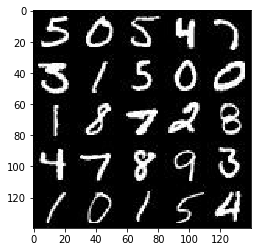

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

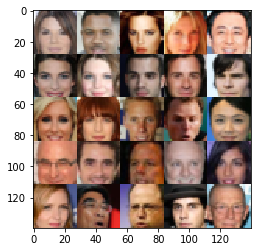

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real' )
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        alpha = 0.1 #FIXME
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha = 0.1
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xdim now
        
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 50
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: learning_rate})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 0.6866... Generator Loss: 1.9134


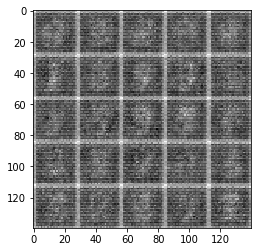

Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 0.3006
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 0.4084


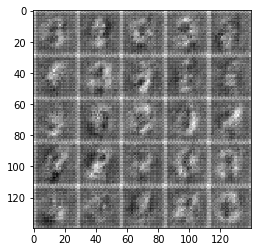

Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 0.9378
Epoch 1/2... Discriminator Loss: 0.8092... Generator Loss: 1.0728
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.3719
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 1.7778


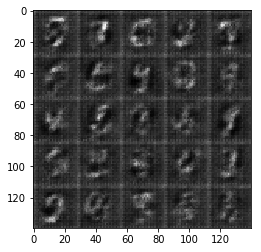

Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 0.9765
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 1.3878
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.5529


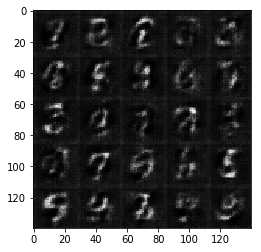

Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 2.3460
Epoch 1/2... Discriminator Loss: 0.7245... Generator Loss: 0.9950
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 2.0565
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 2.5672


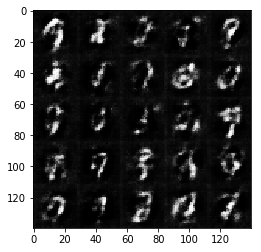

Epoch 1/2... Discriminator Loss: 0.5421... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 0.5623... Generator Loss: 1.8683
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 1.2902
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 2.6316


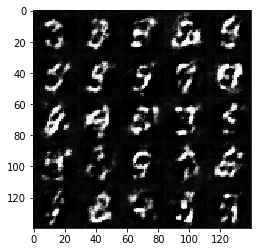

Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 1.2234
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 0.9152
Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 2.0819
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 0.9909
Epoch 1/2... Discriminator Loss: 0.6868... Generator Loss: 0.9640


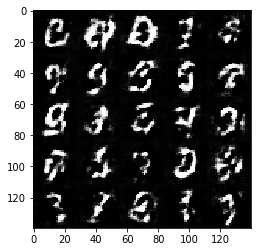

Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 0.6694... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 1.6530
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 1.5592
Epoch 1/2... Discriminator Loss: 0.5804... Generator Loss: 1.3769


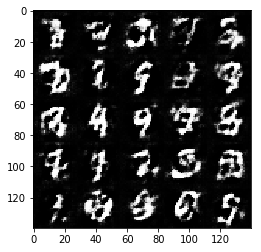

Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 0.9995
Epoch 1/2... Discriminator Loss: 0.4305... Generator Loss: 2.1375
Epoch 1/2... Discriminator Loss: 0.6710... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 1.7512
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 0.9650


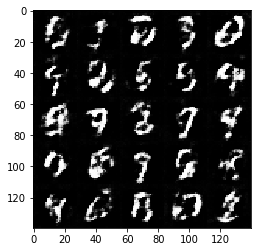

Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 0.8442... Generator Loss: 2.9051
Epoch 1/2... Discriminator Loss: 0.5536... Generator Loss: 1.3389
Epoch 1/2... Discriminator Loss: 0.6398... Generator Loss: 1.0890
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 0.6203


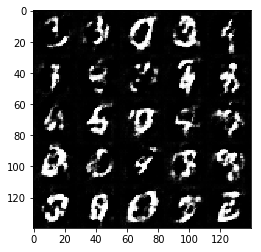

Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 1.9522
Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 1.6992
Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 1.4331


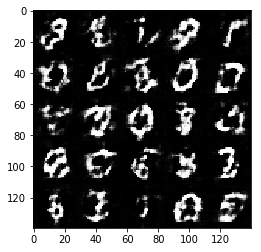

Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 2.7589
Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 0.4695... Generator Loss: 1.5365
Epoch 1/2... Discriminator Loss: 0.5618... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 0.4966... Generator Loss: 1.3860


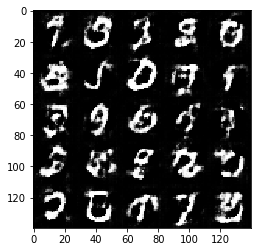

Epoch 1/2... Discriminator Loss: 0.6671... Generator Loss: 1.1839
Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 2.0218
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 2.5311
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.6418


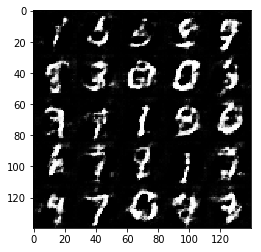

Epoch 1/2... Discriminator Loss: 0.5650... Generator Loss: 2.8089
Epoch 1/2... Discriminator Loss: 0.7878... Generator Loss: 0.9919
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 0.8306... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 0.5143... Generator Loss: 1.3247


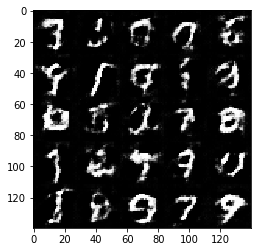

Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 1.2303
Epoch 1/2... Discriminator Loss: 0.4915... Generator Loss: 1.9217
Epoch 1/2... Discriminator Loss: 0.7256... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 0.5912... Generator Loss: 1.3900


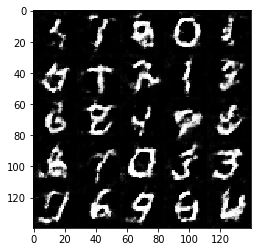

Epoch 1/2... Discriminator Loss: 0.6175... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 1.9430
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 1.2566
Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 1.5271


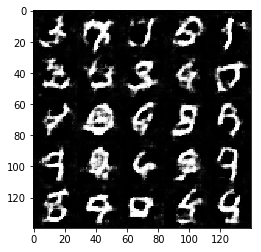

Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.4253
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.0797
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 1.2582
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 1.1620


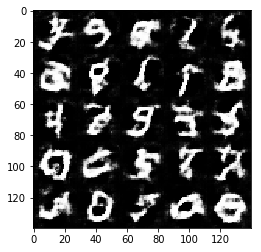

Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.3022
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 1.2811
Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.6569


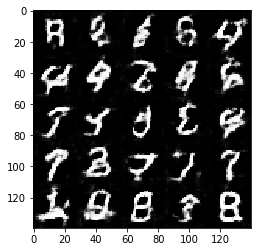

Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 0.7265
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 1.4919
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 1.4057
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 0.5949


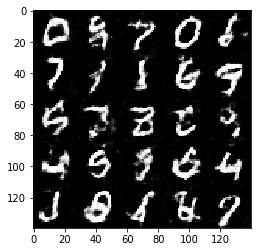

Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 1.7951
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.4443
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 0.6532
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 2.2198


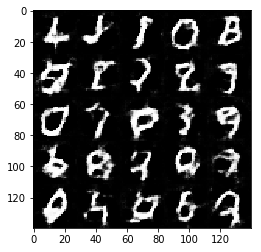

Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 0.7799... Generator Loss: 1.9693
Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 1.3441
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.8041
Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 1.4725


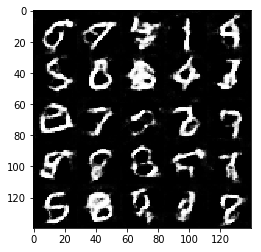

Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 0.8577... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 1.1200
Epoch 1/2... Discriminator Loss: 0.5684... Generator Loss: 1.6404
Epoch 1/2... Discriminator Loss: 0.4246... Generator Loss: 1.8624


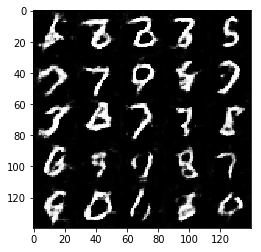

Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.4166
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 1.8248
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 0.6181


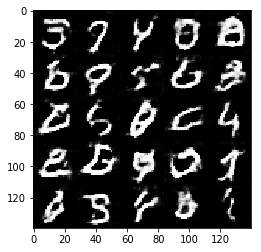

Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 1.3475
Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 1.7741


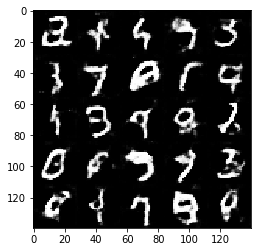

Epoch 1/2... Discriminator Loss: 0.4772... Generator Loss: 1.9756
Epoch 1/2... Discriminator Loss: 0.6353... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 0.6391... Generator Loss: 1.0677
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.1355
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 0.9888


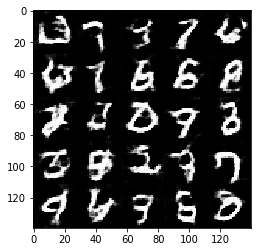

Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 0.5667... Generator Loss: 1.3194
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.1002
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 0.9073


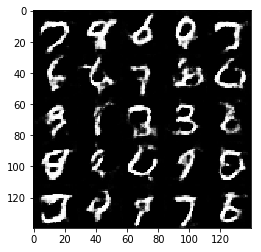

Epoch 1/2... Discriminator Loss: 0.6302... Generator Loss: 1.9468
Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 1.3745
Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 0.9378... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 1.0368


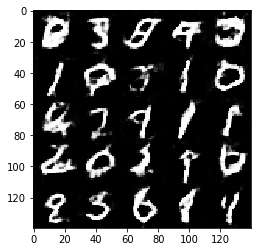

Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 1.5252
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 1.7545


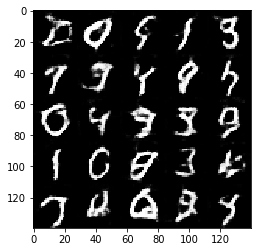

Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.6866... Generator Loss: 1.2036
Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 1.4982


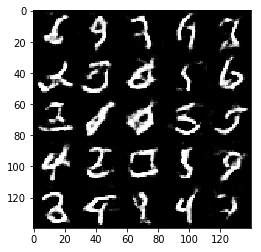

Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 0.6010... Generator Loss: 2.4406
Epoch 1/2... Discriminator Loss: 0.5061... Generator Loss: 1.5301
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 0.6954


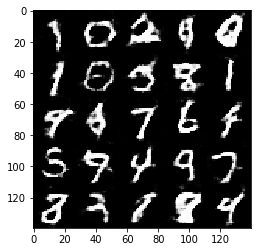

Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 1.2435
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 0.8419
Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 0.9512
Epoch 1/2... Discriminator Loss: 0.5148... Generator Loss: 1.4489
Epoch 1/2... Discriminator Loss: 0.4810... Generator Loss: 1.3543


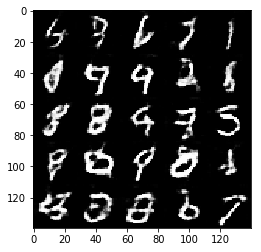

Epoch 1/2... Discriminator Loss: 0.6021... Generator Loss: 1.7500
Epoch 1/2... Discriminator Loss: 0.5319... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 0.7787... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 0.8768


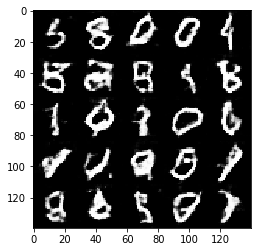

Epoch 1/2... Discriminator Loss: 0.5431... Generator Loss: 1.3377
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 0.4725... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.3707


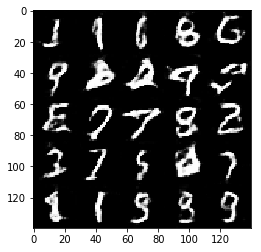

Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.2243
Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 1.2342
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 0.5506... Generator Loss: 1.1851


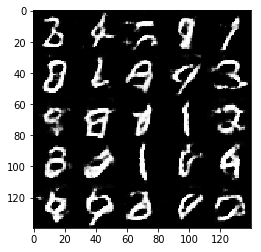

Epoch 1/2... Discriminator Loss: 0.5182... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.0187
Epoch 1/2... Discriminator Loss: 0.5076... Generator Loss: 1.7271
Epoch 1/2... Discriminator Loss: 0.5227... Generator Loss: 1.3184
Epoch 1/2... Discriminator Loss: 0.5869... Generator Loss: 1.2805


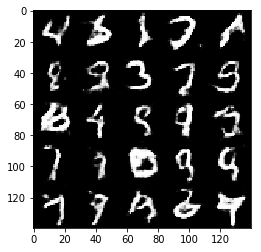

Epoch 1/2... Discriminator Loss: 0.4952... Generator Loss: 1.5556
Epoch 1/2... Discriminator Loss: 0.6414... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 0.7488... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 0.5522... Generator Loss: 1.1958


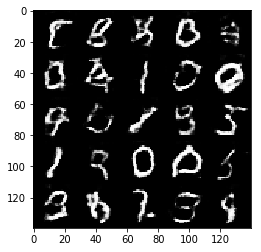

Epoch 1/2... Discriminator Loss: 0.6336... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 1.3333
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 1.1229
Epoch 1/2... Discriminator Loss: 0.5786... Generator Loss: 1.6895
Epoch 1/2... Discriminator Loss: 0.6124... Generator Loss: 1.0309


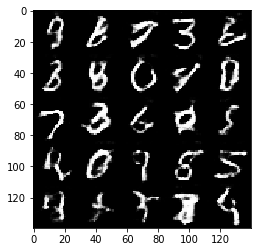

Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 0.4104... Generator Loss: 1.6913
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 0.7101


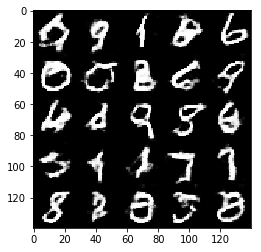

Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 0.4550... Generator Loss: 1.3265
Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 1.1642
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.4343


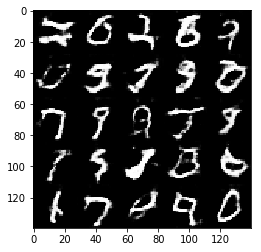

Epoch 2/2... Discriminator Loss: 0.4377... Generator Loss: 1.6211
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.5750... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 1.3720
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 0.7979


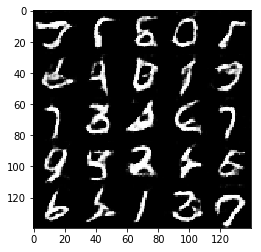

Epoch 2/2... Discriminator Loss: 0.3627... Generator Loss: 1.9422
Epoch 2/2... Discriminator Loss: 0.3291... Generator Loss: 2.4429
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.0205
Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 1.3377
Epoch 2/2... Discriminator Loss: 0.3204... Generator Loss: 1.8028


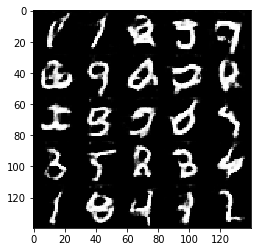

Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.1152
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 1.3772


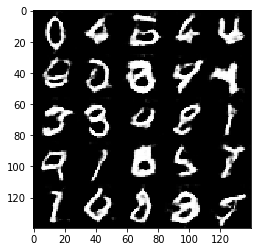

Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 1.5222
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 0.3138... Generator Loss: 1.8456
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 0.7192


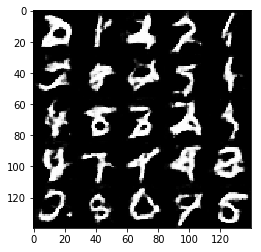

Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 1.6452
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 1.2318
Epoch 2/2... Discriminator Loss: 0.4368... Generator Loss: 1.8117


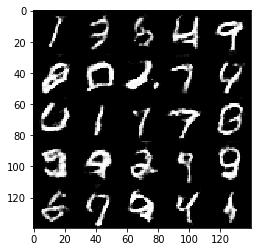

Epoch 2/2... Discriminator Loss: 0.4702... Generator Loss: 1.9535
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.2678
Epoch 2/2... Discriminator Loss: 0.4516... Generator Loss: 1.3536
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 1.3830


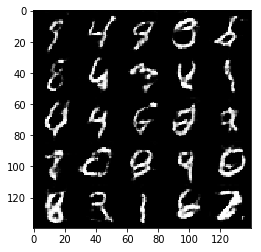

Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 1.1996
Epoch 2/2... Discriminator Loss: 0.5772... Generator Loss: 1.7100
Epoch 2/2... Discriminator Loss: 0.4586... Generator Loss: 1.4310
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.5745


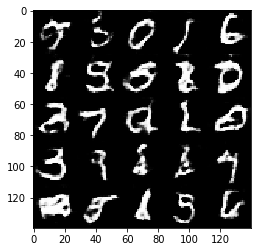

Epoch 2/2... Discriminator Loss: 0.3534... Generator Loss: 1.5410
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.6215
Epoch 2/2... Discriminator Loss: 1.6203... Generator Loss: 0.2956
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 0.7987
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 0.7192


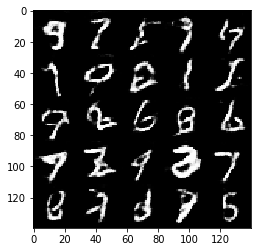

Epoch 2/2... Discriminator Loss: 0.2449... Generator Loss: 2.0415


KeyboardInterrupt: 

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.6434


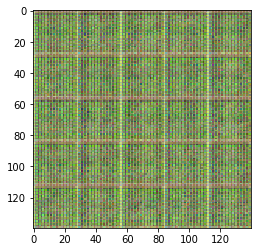

Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 1.7108
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 3.1804
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 2.1172


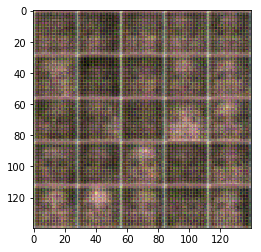

Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.8801
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.3940
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.6912


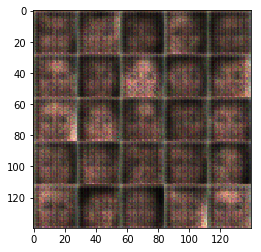

Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.7875


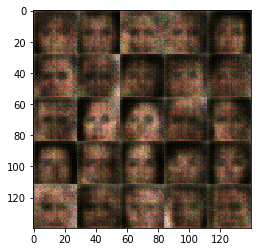

Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.7349
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.8957


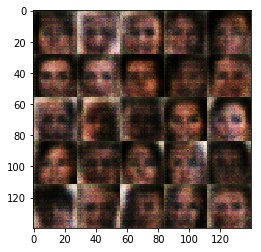

Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.9532


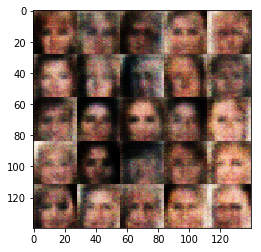

Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 0.9414


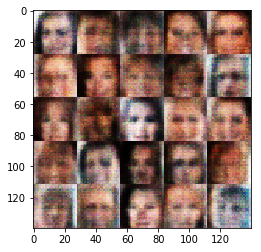

Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 2.1160
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.5888


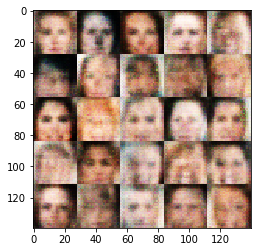

Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.2480
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.0060


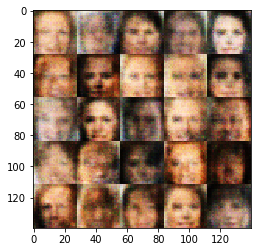

Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.4366
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 0.8654


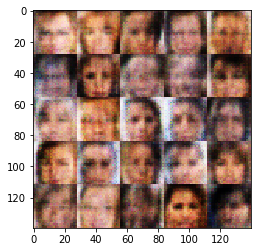

Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.8558


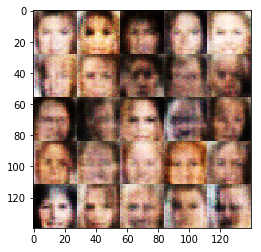

Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.4357


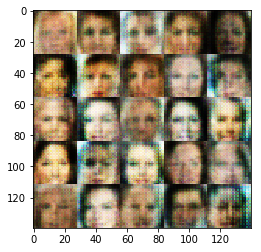

Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.7650


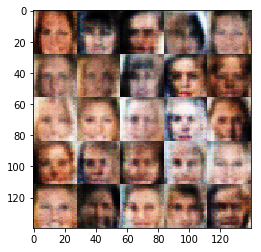

Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.6432


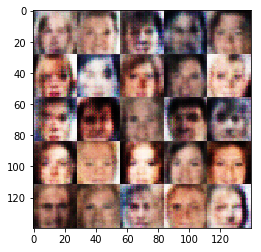

Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.9066


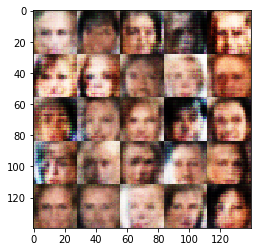

Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.5958


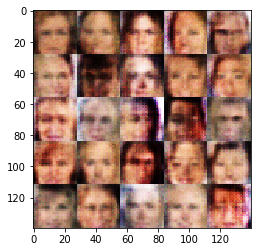

Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.0311


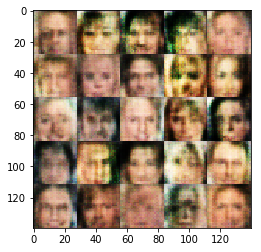

Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.4271


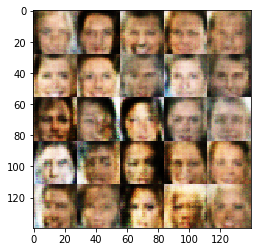

Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5327


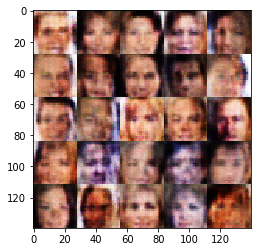

Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.5822


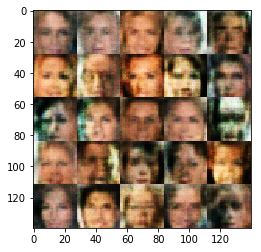

Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.6220


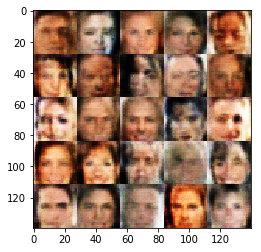

Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.8088


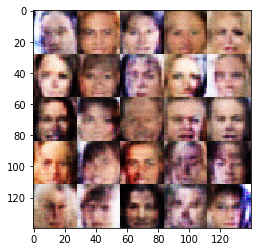

Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.5010


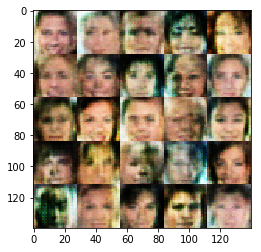

Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.6522


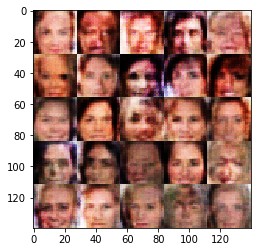

Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.8148


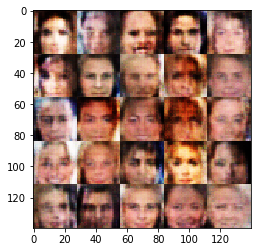

Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.6126


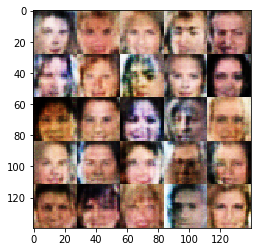

Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.7852


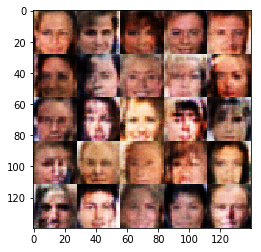

Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.4980


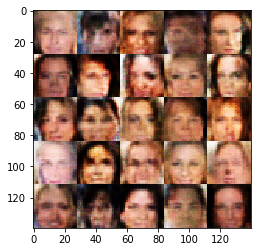

Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.5903


KeyboardInterrupt: 

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.